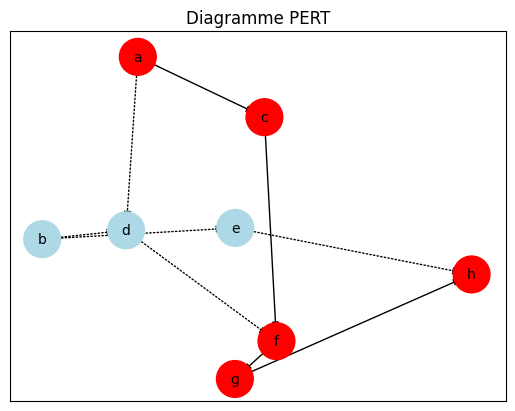


Résultats de l'analyse PERT:

Tâche | Durée | Début tôt | Fin tôt | Début tard | Fin tard | Marge
---------------------------------------------------------------------------
a     |     10 |         0 |      10 |          0 |       10 |     0
b     |      8 |         0 |       8 |          9 |       17 |     9
c     |     12 |        10 |      22 |         10 |       22 |     0
d     |      5 |        10 |      15 |         17 |       22 |     7
e     |      7 |         8 |      15 |         43 |       50 |    35
f     |     15 |        22 |      37 |         22 |       37 |     0
g     |     13 |        37 |      50 |         37 |       50 |     0
h     |      8 |        50 |      58 |         50 |       58 |     0

Chemin critique: a -> c -> f -> g -> h
Durée totale du projet:  58

Résultats exportés vers results.csv


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

class Task:
    def __init__(self, name, duration, dependencies=None):
        self.name = name
        self.duration = duration
        self.dependencies = dependencies or []
        self.earliest_start = 0
        self.earliest_finish = 0
        self.latest_start = 0
        self.latest_finish = 0
        self.total_float = 0

class PertAnalyzer:
    def __init__(self):
        self.tasks = {}
        self.critical_path = []

    def load_from_csv(self, filepath):
        df = pd.read_csv(filepath)

        for _, row in df.iterrows():
            deps = []
            if pd.notna(row['DEPENDENCIES']) and row['DEPENDENCIES'] != 'NONE':
                deps = row['DEPENDENCIES'].split()

            self.add_task(
                name=row['TASK'].lower(),
                duration=int(row['DURATION']),
                dependencies=[dep.lower() for dep in deps]
            )

    def add_task(self, name, duration, dependencies=None):
        self.tasks[name] = Task(name, duration, dependencies)

    def calculate_forward_pass(self):
        calculated = set()

        while len(calculated) < len(self.tasks):
            for name, task in self.tasks.items():
                if name in calculated:
                    continue

                if not task.dependencies:
                    task.earliest_start = 0
                    task.earliest_finish = task.duration
                    calculated.add(name)
                    continue

                if all(dep in calculated for dep in task.dependencies):
                    task.earliest_start = max(
                        self.tasks[dep].earliest_finish
                        for dep in task.dependencies
                    )
                    task.earliest_finish = task.earliest_start + task.duration
                    calculated.add(name)

    def calculate_backward_pass(self):
        project_end = max(task.earliest_finish for task in self.tasks.values())
        calculated = set()

        for task in self.tasks.values():
            task.latest_finish = project_end
            task.latest_start = project_end - task.duration

        while len(calculated) < len(self.tasks):
            for name, task in self.tasks.items():
                if name in calculated:
                    continue

                successors = [
                    t for t in self.tasks.values()
                    if name in t.dependencies
                ]

                if not successors:
                    task.latest_finish = project_end
                    task.latest_start = task.latest_finish - task.duration
                    calculated.add(name)
                    continue

                if all(succ.name in calculated for succ in successors):
                    task.latest_finish = min(
                        self.tasks[succ.name].latest_start
                        for succ in successors
                    )
                    task.latest_start = task.latest_finish - task.duration
                    calculated.add(name)

    def calculate_floats(self):
        for task in self.tasks.values():
            task.total_float = task.latest_start - task.earliest_start

    def find_critical_path(self):
        self.critical_path = [
            task.name for task in self.tasks.values()
            if task.total_float == 0
        ]

    def analyze(self):
        self.calculate_forward_pass()
        self.calculate_backward_pass()
        self.calculate_floats()
        self.find_critical_path()

    def print_results(self):
        print("\nRésultats de l'analyse PERT:")
        print("\nTâche | Durée | Début tôt | Fin tôt | Début tard | Fin tard | Marge")
        print("-" * 75)

        for name, task in sorted(self.tasks.items()):
            print(f"{name:5} | {task.duration:6} | {task.earliest_start:9} | "
                  f"{task.earliest_finish:7} | {task.latest_start:10} | "
                  f"{task.latest_finish:8} | {task.total_float:5}")

        print("\nChemin critique:", " -> ".join(self.critical_path))
        print("Durée totale du projet: ",
              max(task.earliest_finish for task in self.tasks.values()))

    def export_to_csv(self, filepath):
        results = []
        for name, task in self.tasks.items():
            results.append({
                'Task': name,
                'Duration': task.duration,
                'Earliest_Start': task.earliest_start,
                'Earliest_Finish': task.earliest_finish,
                'Latest_Start': task.latest_start,
                'Latest_Finish': task.latest_finish,
                'Total_Float': task.total_float,
                'Is_Critical': name in self.critical_path
            })

        results_df = pd.DataFrame(results)
        results_df.to_csv(filepath, index=False)
        print(f"\nRésultats exportés vers {filepath}")


class PertGraphVisualizer:
    def __init__(self, pert_analyzer):
        self.pert_analyzer = pert_analyzer

    def draw_graph(self):
        G = nx.DiGraph()

        for name, task in self.pert_analyzer.tasks.items():
            G.add_node(name, duration=task.duration)
            for dependency in task.dependencies:
                G.add_edge(dependency, name)

        critical_path = set(self.pert_analyzer.critical_path)

        node_colors = ['red' if node in critical_path else 'lightblue' for node in G.nodes()]

        edge_styles = [
            'solid' if (u in critical_path and v in critical_path) else 'dotted'
            for u, v in G.edges()
        ]

        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)

        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

        for i, (u, v) in enumerate(G.edges()):
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=[(u, v)],
                style=edge_styles[i],
                edge_color='black'
            )

        plt.title("Diagramme PERT")
        plt.show()


pert = PertAnalyzer()
pert.load_from_csv('tasks.csv')  
pert.analyze()
visualizer = PertGraphVisualizer(pert)
visualizer.draw_graph()

pert.print_results()
pert.export_to_csv('results.csv') 
